## PDX Stock Market Analysis Workgroup

### feature extraction / reduction / engineering

#### John Burt

My project goal is to create a model that can predict the mean stock value at a specific time in the the future. 

The goal of this notebook is to generate a useful set of features to use as inputs for the model.

Each feature will be a time series of (daily) weighted means of stocks grouped by similarity (covariance of stock value time series). 

#### Why do this:
- Feature reduction: these features will be used as proxies for related stocks for the forecasting model, reducing model input by about 30:1.
- Feature transformation: the output will be normalized and detrended, which should help with (short term) prediction model learning.
- Useful procedure for other types of analysis. For example, you might want to forecast a specific stock, in which case you might use a similar process to find stocks that behave similarly to the target stock.

#### My method: 
- Select all stocks that start on or before a specified date.
- Transform and normalize stock values.
- Pairwise correlate all stock time series to create a similarity matrix.
- Generate a 2D mapping of stocks, where similar ones are closer.
- Cluster analysis to group similar stocks.
- Generate features using the cluster groupings.


#### Workgroup members: 
- John Burt
- Sonny Nallamilli
- Matt Leffers
- Robert Lugg
- Purbasha Chatterjee
- Manish Kumar Saraf

Workgroup Slack channel:
https://pdxdsworkgroup.slack.com


Note: this code assumes that data files are located in same folder as notebook

data files:

http://dive-into.info/2149/stocks-us-adjClose.csv

http://dive-into.info/2149/stocks-us-moreData.zip


## load data from csv file

- Set up plot environment.
- Load stock market data from csv into pandas dataframe
- Convert date strings to date values

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
import pandas as pd
pd.options.display.max_columns = 100
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import numpy as np

from datetime import datetime

pd.options.display.max_rows = 100

#*********************************************************
#Two datasets are available: a training set and a test set. 
#We'll be using the training set to build our predictive model 
#and the testing set to score it and generate an output file to 
#submit on the Kaggle evaluation system.

# load the basic stock market value dataset, set date (col 0) as index
rawdata = pd.read_csv('stocks-us-adjClose.csv', index_col=0)

# convert date strings to datetimeindex
rawdata.index = pd.DatetimeIndex(pd.to_datetime(rawdata.index))

# look at what we've got:
#data.head()
#data.describe()

## Pre-process stock data: fill/interpolate missing days, log, range

Pick a date and keep only stocks that have data going back that far.

Calculate the log of the mean stock value for this set. This will be our target output.

Transform each stock value by log(value)/max(log(stock values)). This will result in all series normalized to a range between 0-1

In [2]:
# Choose a start date. 
# We need to have a set of stocks that start on or before this date to ensure a complete time series.
# We pick a date that is as early as possible, but includes a good number of stocks.
startdate = datetime(2000, 1, 1)

# take only stock values after the start date
# make a copy of raw data. We will transform this new copy
xfdata = rawdata.loc[rawdata.index >= startdate].copy()

# log transform the stock values 
xfdata = np.log(xfdata)

# delete any stocks with NaN (missing) stock values after the start date
for col in xfdata:
    if any(pd.isnull(xfdata[col])):
        xfdata = xfdata.drop(col,axis=1)

# add any missing dates and use interpolation to estimate the missing days' stock values 
idx = pd.date_range(xfdata.index.min(), xfdata.index.max())
xfdata = xfdata.reindex(idx)
xfdata = xfdata.apply(pd.Series.interpolate, method="cubic")

print("from original dataset of %d stocks and %s days, we are using %d stocks and %d days"%
      (rawdata.shape[1],rawdata.shape[0],xfdata.shape[1],xfdata.shape[0]))

# Generate mean log stock value data to use for training / testing.
# I am using log data for model target output because I think that model fitting 
#  will work better with linearized data.
# Note that we can then convert model output to real stock values using np.exp(stock_mean).
stock_mean = xfdata.mean(axis=1)

# scale each stock to range between 0-1
for col in xfdata:
    valmin = xfdata[col].min()
    valmax = xfdata[col].max()
    xfdata[col] = (xfdata[col]-valmin)/(valmax-valmin)

from original dataset of 710 stocks and 12032 days, we are using 338 stocks and 6459 days


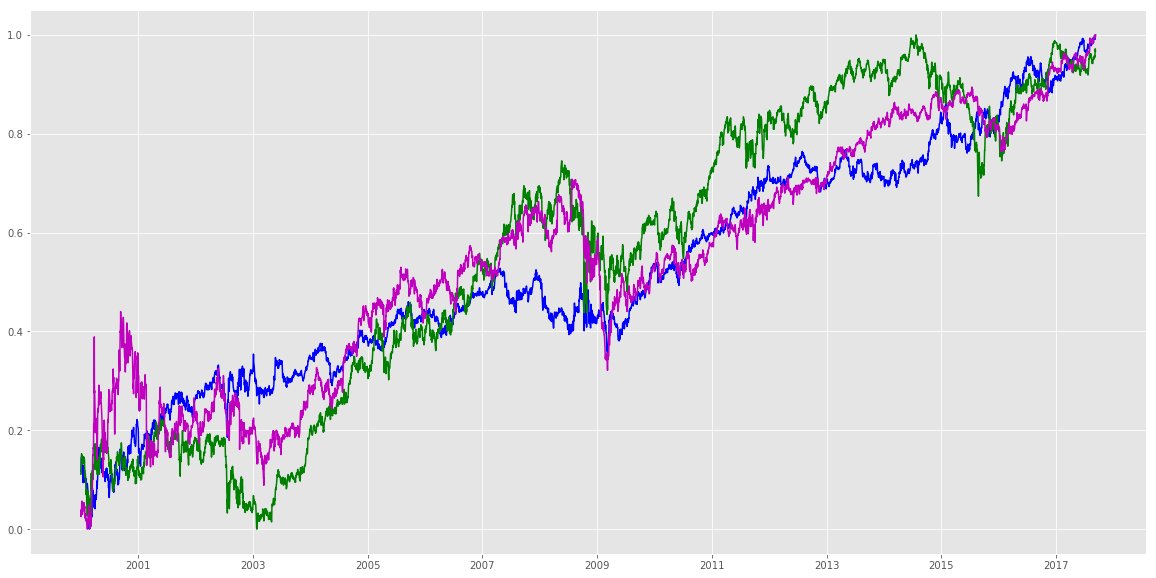

In [3]:
# set True to plot some log xformed stock data to see what the interpolation did:
if True:
    plt.figure(figsize=(20, 10))
    numdays = xfdata.shape[0] 
    #numdays = 60
    ax1 = plt.plot(xfdata.index[:numdays] ,xfdata.iloc[:numdays,0],"b-")
    ax2 = plt.plot(xfdata.index[:numdays] ,xfdata.iloc[:numdays,1],"g-")
    ax3 = plt.plot(xfdata.index[:numdays] ,xfdata.iloc[:numdays,-1],"m-")      

### Transform the stock data using a difference function. 

Transform the stock data into day-to-day differences in stock value. This removes the overall stock market growth trend, which will cause problems for correlation / covariance estimates.

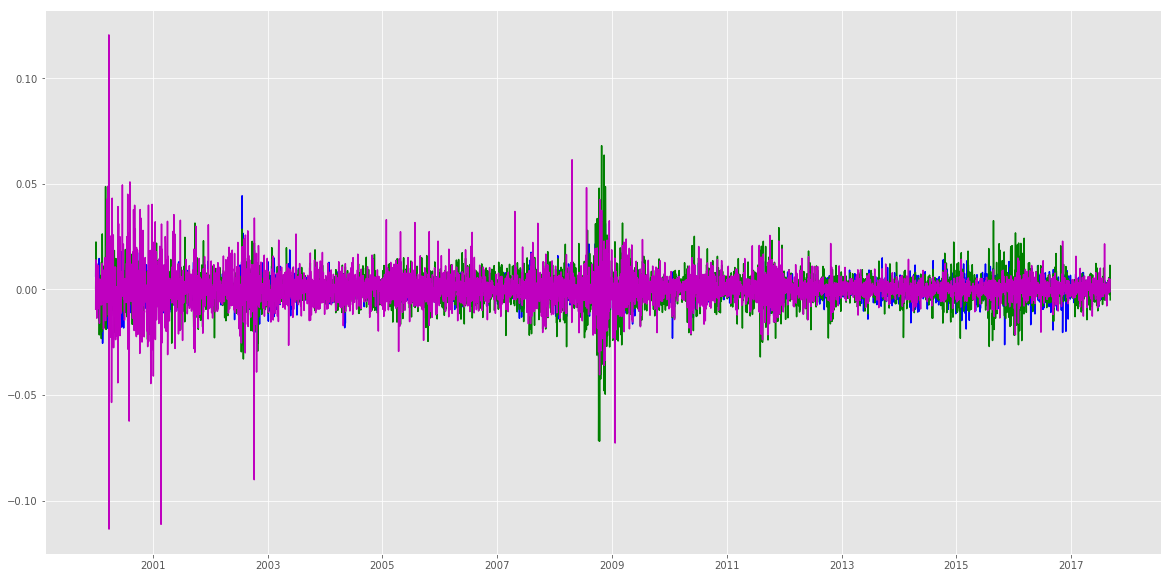

In [4]:
# Use a difference fn to remove the growth trend and leave the day to day stock variation.
# This is necessary to do before correlation/covariance, etc operations.
diffdata = pd.DataFrame(np.diff(xfdata.values,axis=0),index=xfdata.index[:-1], columns=xfdata.columns)

# set True to plot some differenced stock data:
if True:
    plt.figure(figsize=(20, 10))
    numdays = diffdata.shape[0] 
    #numdays = 60
    ax1 = plt.plot(diffdata.index[:numdays] ,diffdata.iloc[:numdays,0],"b-")
    ax2 = plt.plot(diffdata.index[:numdays] ,diffdata.iloc[:numdays,1],"g-")
    ax3 = plt.plot(diffdata.index[:numdays] ,diffdata.iloc[:numdays,-1],"m-")

### Save the interpolated and differenced stock data for fast loading in later analyses:

In [5]:
import pickle
diffed_filename = "stocks-us-adjClose_stocks_diffed.pkl"

# save the diffed stock data to file for another notebook to use for analysis
with open(diffed_filename, 'wb') as handle:
    pickle.dump(diffdata, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("diffed stock data saved to pkl file")    

diffed stock data saved to pkl file


## Create and fit a covariance model. 

Generates a covariance matrix, which we can use for mapping and cluster analysis.

There are several other methods, see:
http://scikit-learn.org/stable/modules/covariance.html

Note that the GraphLassoCV method creates a very sparse martix (most comparisons have a covariance of 0). This is useful for some analyses, but not if we want to generate a 2D mapping. 

Note: I'm using as inspiration: Visualizing the stock market structure
http://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html

In [6]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

# standardize data for model
X = diffdata.copy()
X /= X.std(axis=0)

# Sparse inverse covariance
# note: this is used in the scikit learn example, but it doesn't create a useful matrix.
#edge_model = covariance.GraphLassoCV(verbose=True).fit(X)

# Empirical covariance
edge_model = covariance.EmpiricalCovariance().fit(X)

# set True to show the covariance matrix result
if False:
    fig, ax1 = plt.subplots(figsize=(10, 10))
    ax = ax1.matshow(edge_model.covariance_)

## Map the covariance matrix onto a 2D space. 

Ideally, the covariance matrix mapping will yield a clustering of stocks that have similar historical behavior.

Note that I have tried several mapping methods. The one used here is [t-distributed Stochastic Neighbor Embedding (t-SNE)](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE), which generates a good looking map. Whether this map is meaningful, or whether some other method is better, will require further proofing.

For more on this see:
http://scikit-learn.org/stable/modules/manifold.html

However, it is possible that there are other better mappings, or that some mapping will work better if the default parameters are further tweaked.

In [7]:
# #############################################################################
# Find a low-dimension embedding for visualization and cluster analysis: 
# find the best position of the nodes (the stocks) on a 2D plane

# alternate mapping models:
#node_position_model = manifold.LocallyLinearEmbedding(
#    n_components=2, eigen_solver='dense', n_neighbors=6)
#node_position_model = manifold.MDS()
#node_position_model = manifold.SpectralEmbedding()

# this seems to work best
# note that the default # dimensions are 2 - you could have more if you want
node_position_model = manifold.TSNE()

# get the 2D coordinates we need
coords = node_position_model.fit_transform(edge_model.covariance_)

## Cluster analysis

Use Kmeans clustering to identify a specified number of groups of correlated stocks. 

These stock groupings will be used to generate our features.

Note that there are many other clustering methods, including ones that decide on their own how many clusters to generate. I chose kmeans because it is straighforward and common, it returns exactly the number of clusters you choose, and it returns cluster centroids, which I will then use in feature generation. 

See:
http://scikit-learn.org/stable/modules/clustering.html

In [8]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA

names = X.columns
symbols = X.columns

# Rotate the data
clf = PCA(n_components=coords.shape[1])
coords = clf.fit_transform(coords)

numclusters = 10
clustermodel = KMeans(n_clusters=numclusters).fit(coords)
centroids = clustermodel.cluster_centers_

eps = (coords.max()-coords.min())/50
#clustermodel = DBSCAN(eps=eps, min_samples=10).fit(coords)
#clustermodel = DBSCAN().fit(coords)
    
labels = clustermodel.labels_
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: contains %d stocks: %s\n' % 
          ((i + 1), len((names[labels == i])), ', '.join(names[labels == i])))

Cluster 1: contains 31 stocks: BK, C, VNO, WABC, BAC, JPM, BBT, FHN, CVBF, FMBI, TRST, CBU, BDN, EQC, FBNC, WASH, KEY, CHFC, NBTB, STBA, TCO, SYBT, TCBK, AKR, CPT, EQR, UBSH, AF, HIW, VTR, UVSP

Cluster 2: contains 32 stocks: LLY, AVP, BF-A, KR, CL, TSN, BF-B, MYL, GIS, BDX, KMB, CHD, NVO, HUM, JCI, FUN, SWN, TTF, AGN, PDCO, CHK, BAP, RCI, FMS, NVS, PSO, TESO, GEOS, GIL, IX, VIV, BAK

Cluster 3: contains 49 stocks: CAT, IP, MATX, GWW, LPX, GLT, PGR, TRC, L, TGNA, IR, ANAT, KMT, DHR, FUL, MOG-A, CSX, SEIC, IFF, LM, SLM, AXE, CB, SWK, UNM, TIF, PII, SAN, JOE, TEX, PX, MTX, MS, BWA, EMN, ALB, RS, BMO, EME, ERIE, ITT, LAMR, ALV, WDR, FII, GBL, HSBC, MFC, BLK

Cluster 4: contains 43 stocks: GFI, SENEB, AEM, MUX, VBF, CMU, MGF, NNY, NCA, MIN, SUN, KTF, MEN, KSM, CXH, NUM, EQS, TRIB, MIY, BKN, NMT, NPV, BBSI, RVSB, ARWR, MED, NMRX, MPAA, HMY, AKO-A, VCO, TGS, PAAS, BREW, AGX, IPXL, SNAK, NTL, NICK, CFFI, AMRB, NAD, KTP

Cluster 5: contains 28 stocks: SNE, ADI, CTS, TMO, INTC, KYO, HRS, PAYX, 

### Function to plot the stocks on our mapping with the clusters identified.

In [9]:
def plot_stock_map(coords, cluster_labels, symbols, centroids=[None], show_symbols=False, show_colors=True):

    # #############################################################################
    # Visualization
    plt.figure(1, facecolor='w', figsize=(15, 10))
    plt.clf()
    ax = plt.axes([0., 0., 1., 1.])
    plt.axis('off')
    
    # Plot the nodes 
    if show_colors:
        plt.scatter(coords[:,0], coords[:,1], s=100, c=cluster_labels, cmap=plt.cm.spectral)
    else:
        plt.scatter(coords[:,0], coords[:,1], s=50,c='k')
    
    # plot centroids, if they were passed
    if len(centroids) > 0:
        plt.scatter(centroids[:, 0],centroids[:, 1], marker = "x", s=200, linewidths = 5, zorder = 10)

    # Add a stock symbol label to each node. The challenge here is that we want to
    # position the labels to avoid overlap with other labels
    if show_symbols:
        for index, (symbol, label, (x, y)) in enumerate(
                zip(symbols, cluster_labels, coords)):

            dx = x - coords[:,0]
            dx[index] = 1
            dy = y - coords[:,1]
            dy[index] = 1
            this_dx = dx[np.argmin(np.abs(dy))]
            this_dy = dy[np.argmin(np.abs(dx))]
            if this_dx > 0:
                horizontalalignment = 'left'
                x = x + .002
            else:
                horizontalalignment = 'right'
                x = x - .002
            if this_dy > 0:
                verticalalignment = 'bottom'
                y = y + .002
            else:
                verticalalignment = 'top'
                y = y - .002
            #plt.text(x, y, name, size=10,
            plt.text(x, y, symbol, size=15,
                     horizontalalignment=horizontalalignment,
                     verticalalignment=verticalalignment,
                     bbox=dict(facecolor='w',
                     #          edgecolor=plt.cm.spectral(label / float(n_labels)),
                               edgecolor='w',
                               alpha=.6)
                    )

    plt.xlim(coords[:,0].min() - .05 * coords[:,0].ptp(),
             coords[:,0].max() + .05 * coords[:,0].ptp(),)
    plt.ylim(coords[:,1].min() - .03 * coords[:,1].ptp(),
             coords[:,1].max() + .03 * coords[:,1].ptp())

    plt.show()

### Plot the clustering results

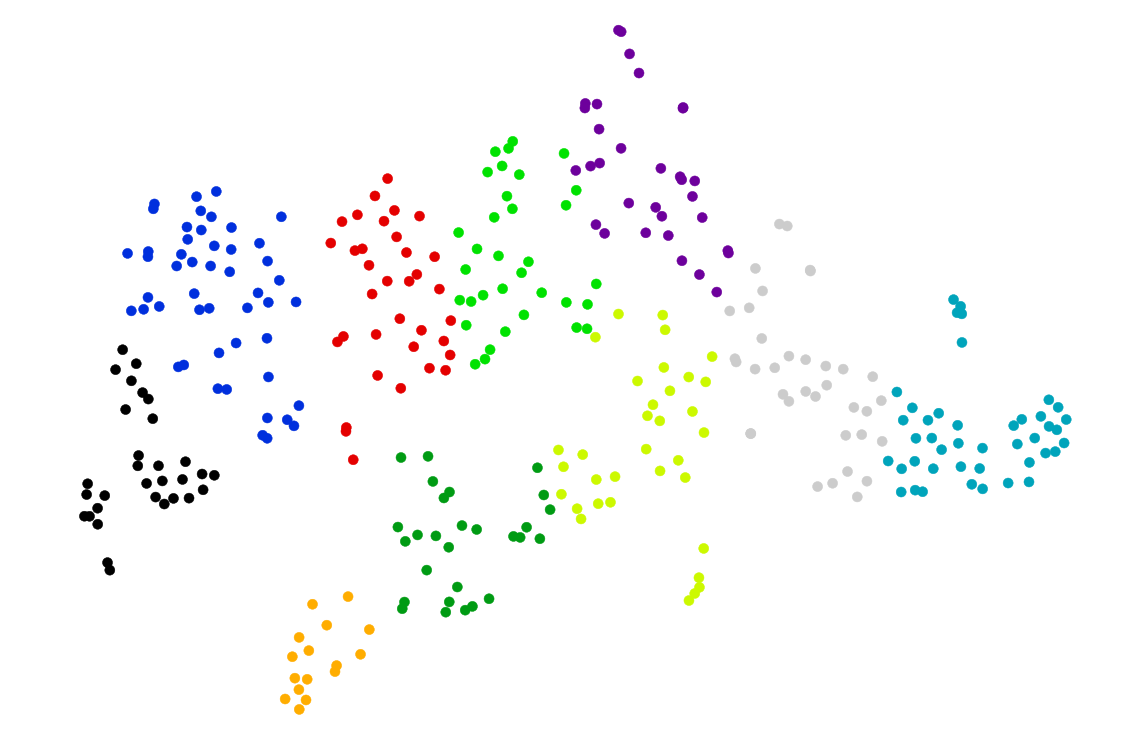

In [10]:
plot_stock_map(coords, labels, symbols, [], show_symbols=False, show_colors=True)

### Show the map with stock symbols

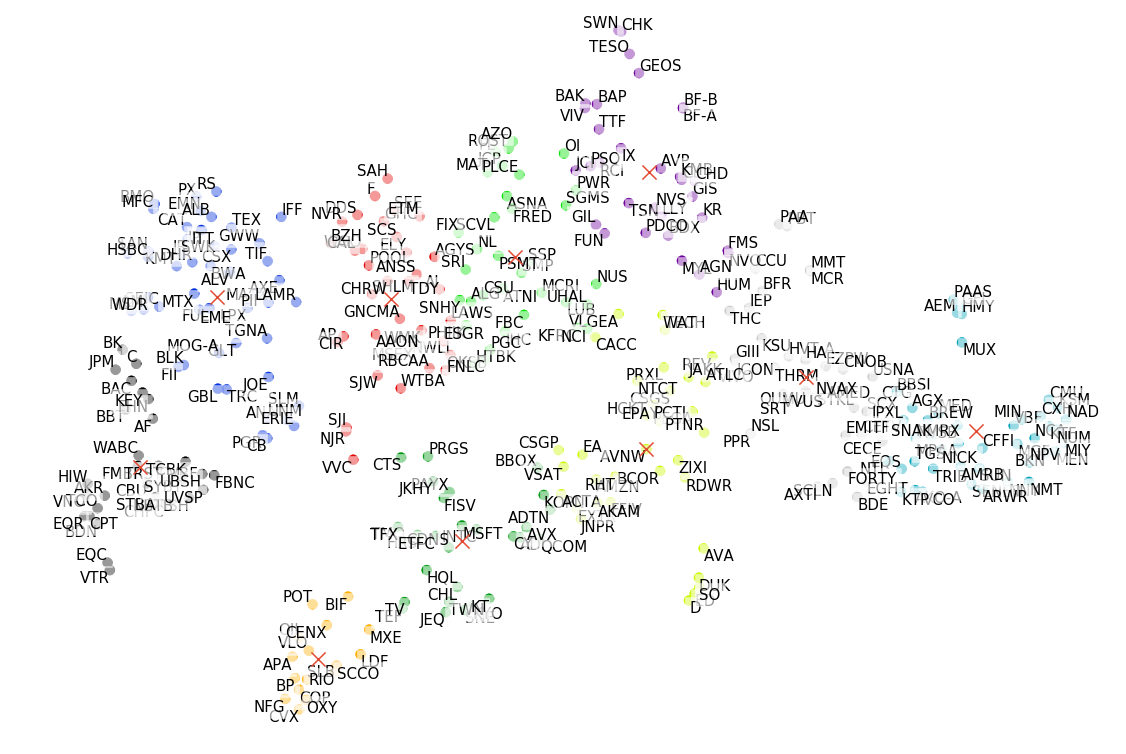

In [11]:
plot_stock_map(coords, labels, symbols, centroids, show_symbols=True)

Generate features

Generate time a series feature for each cluster.

The output will be the average of each stock's value in the cluster, weighted by distance from centroid.

The result will be used as input for a prediction model.


In [12]:
from scipy.spatial import distance

labelnums = set(labels)
numclusters =  len(labelnums)
clusternames = list(map(str, labelnums))
serieslen = stock_mean.shape[0]

# create a new dataframe with same time index as original data, and train/test output 
# Use cluster # as cluster name for ease of analysis
cdf = pd.DataFrame(index=stock_mean.index, columns=clusternames)

# for each cluster, 
#  generate a list of stock symbols and a weight for each stock based on distance from centroid
for labelnum in labelnums:
    
    # get indices to stocks in this cluster
    index, = np.where(labels==labelnum)
    
    # number of stocks in this cluster
    numstocks = index.shape[0]

    # test to verify getting cluster data right: 
    #   choose random stock indices - should be greater distance values than cluster selections
    #arr = np.arange(labels.shape[0])
    #np.random.shuffle(arr)
    #index = arr[:numstocks]
    
    # get list of symbols of stocks that belong to this cluster
    symbols = X.columns[index]
    print("cluster %d stocks: %s"%(labelnum,",".join(symbols)))
    
    # Generate weights for each stock in this cluster, based on euclidean distance to centroid.
    # First get distances
    dist = np.zeros((numstocks,))
    for j, stockindex in zip(range(numstocks),index):
        dist[j] = distance.euclidean(coords[stockindex,:],centroids[labelnum, :])
    weight = dist.max() - dist + (dist.max()-dist.min())/5

    # create a time series to contain the feature values for this cluster
    ps = pd.Series(np.zeros((serieslen,)), index=xfdata.index)
    
    # calculate the feature values
    weightsum = weight.sum()
    for i in range(serieslen):
        ps[i] = (xfdata[symbols].iloc[i,:] * weight).sum() / weightsum
    
    print("cluster %d time series: min=%1.3f, max=%1.3f, mean=%1.3f\n"%(labelnum, ps.min(),ps.max(),ps.mean()))
    
    # add the new time series to the feature dataset
    cdf[clusternames[labelnum]] = ps

cluster 0 stocks: BK,C,VNO,WABC,BAC,JPM,BBT,FHN,CVBF,FMBI,TRST,CBU,BDN,EQC,FBNC,WASH,KEY,CHFC,NBTB,STBA,TCO,SYBT,TCBK,AKR,CPT,EQR,UBSH,AF,HIW,VTR,UVSP
cluster 0 time series: min=0.166, max=0.930, mean=0.578

cluster 1 stocks: LLY,AVP,BF-A,KR,CL,TSN,BF-B,MYL,GIS,BDX,KMB,CHD,NVO,HUM,JCI,FUN,SWN,TTF,AGN,PDCO,CHK,BAP,RCI,FMS,NVS,PSO,TESO,GEOS,GIL,IX,VIV,BAK
cluster 1 time series: min=0.234, max=0.839, mean=0.554

cluster 2 stocks: CAT,IP,MATX,GWW,LPX,GLT,PGR,TRC,L,TGNA,IR,ANAT,KMT,DHR,FUL,MOG-A,CSX,SEIC,IFF,LM,SLM,AXE,CB,SWK,UNM,TIF,PII,SAN,JOE,TEX,PX,MTX,MS,BWA,EMN,ALB,RS,BMO,EME,ERIE,ITT,LAMR,ALV,WDR,FII,GBL,HSBC,MFC,BLK
cluster 2 time series: min=0.181, max=0.886, mean=0.576

cluster 3 stocks: GFI,SENEB,AEM,MUX,VBF,CMU,MGF,NNY,NCA,MIN,SUN,KTF,MEN,KSM,CXH,NUM,EQS,TRIB,MIY,BKN,NMT,NPV,BBSI,RVSB,ARWR,MED,NMRX,MPAA,HMY,AKO-A,VCO,TGS,PAAS,BREW,AGX,IPXL,SNAK,NTL,NICK,CFFI,AMRB,NAD,KTP
cluster 3 time series: min=0.232, max=0.822, mean=0.573

cluster 4 stocks: SNE,ADI,CTS,TMO,INTC,KYO,HRS,PAYX,

### Show feature time series

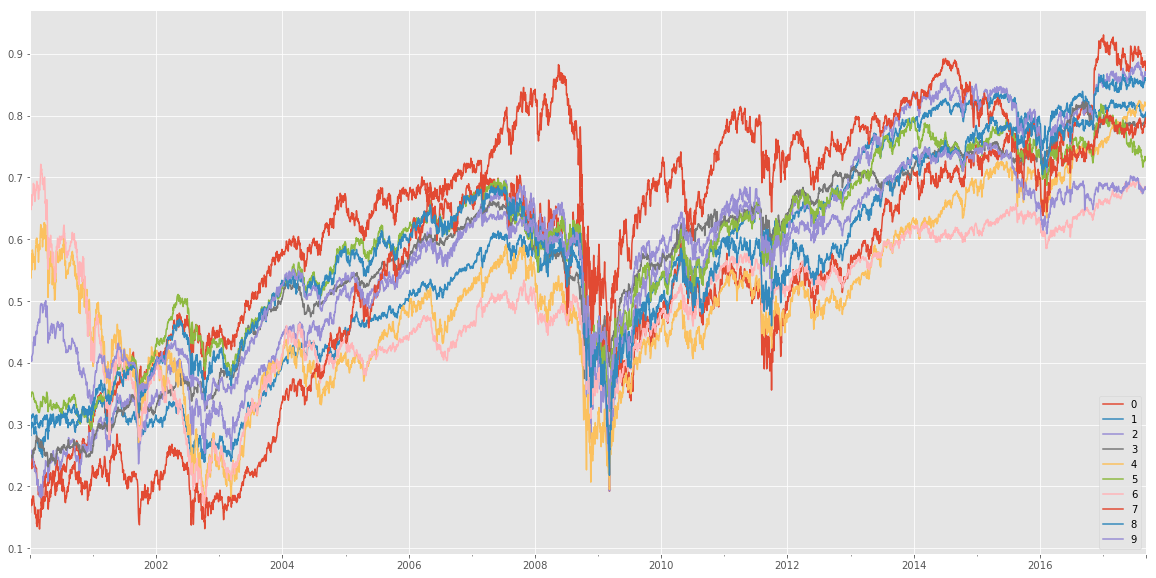

In [13]:
cdf.plot( y=clusternames, kind="line", figsize=(20,10));